In [ ]:
%cd ../..
import datajoint as dj
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import display,clear_output
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import json

from pipeline import lab, experiment, foraging_analysis
from pipeline.plot.foraging_plot import *

In [ ]:
#data.df_behaviortrial=[]

def update_params(df_behaviortrial=None):  # this script make sure that the widgets are synchronized
    plottype = task_selector.value
    if '2' in plottype:
        wr_names = (foraging_analysis.SessionTaskProtocol()*experiment.Session()*lab.WaterRestriction()&'session_task_protocol = 100').fetch('water_restriction_number')
    elif '3' in plottype:
        wr_names = (foraging_analysis.SessionTaskProtocol()*experiment.Session()*lab.WaterRestriction()&'session_task_protocol = 101').fetch('water_restriction_number')
    wr_names = np.unique(wr_names)
    wr_name_selector.options = wr_names
    wr_name = wr_name_selector.value
    subject_id = (lab.WaterRestriction()&'water_restriction_number = "{}"'.format(wr_name)).fetch1('subject_id')

    df_sessions = pd.DataFrame(foraging_analysis.SessionTaskProtocol()*experiment.Session()&'subject_id = {}'.format(subject_id))
    if '2' in plottype:
        needed = df_sessions['session_task_protocol'] == 100
    elif '3' in plottype:
        needed = df_sessions['session_task_protocol'] == 101
    df_sessions=df_sessions[needed]
    if len(df_sessions)>0:
        try:
            session_selector.min = df_sessions['session'].min()
            session_selector.max = df_sessions['session'].max()
        except:
            session_selector.max = df_sessions['session'].max()
            session_selector.min = df_sessions['session'].min()
    else:
        session_selector.min = 0
        session_selector.max = 0
    session_real_foraging = (foraging_analysis.SessionTaskProtocol()&'subject_id = {}'.format(subject_id)).fetch('session_real_foraging')
    metadata_display.value = 'Pretraining session num: {}'.format(sum(session_real_foraging ==0))
    
    
    if type(df_behaviortrial) == pd.DataFrame:
        overall_sum_prob_efficiency =  (foraging_analysis.BlockEfficiency()&'subject_id = {}'.format(subject_id)).fetch('block_effi_sum_p_reward')
        overall_sum_prob_efficiency = overall_sum_prob_efficiency[overall_sum_prob_efficiency != np.array(None)]
        overall_sum_prob_efficiency = np.array([float(x) for x in overall_sum_prob_efficiency])
        metadata_display.value = metadata_display.value + '<br/>  trial number: {}'.format(len(df_behaviortrial)) + '<br/> overall_sum_prob_efficiency : {:.2f}'.format(np.nanmean(overall_sum_prob_efficiency))

        
        
def enable_local_efficiency(dummy=None): # enable controls to calculating local efficiency
    if calculate_efficiency_locally.value:
        setvalue = False
    else:
        setvalue = True
        
    local_bias_sliding_window.disabled= setvalue
    local_bias_matching_window.disabled= setvalue
    local_bias_matching_step.disabled= setvalue
    
    
def plot_stuff(dummy=None): # this script does the plotting
    # generate figure structure
    fig=plt.figure()
    ax1=fig.add_axes([0,0,2,.8])
    ax2=fig.add_axes([0,-.6,2,.4])
    ax3=fig.add_axes([0,-1.6,2,.8])
    ax4=fig.add_axes([0,-2.6,2,.8])
    ax5 = fig.add_axes([0,-3.6,2,.8])
    plt.close(fig)
    
    with output:
        clear_output(wait=True)
        print('waiting for data..')
    # invoke plot functions   
    filters = {'ignore_rate_max':filter_max_ignore_rate.value,
               'averaging_window':plot_choice_averaging_window.value}
    
    local_matching = {'calculate_local_matching': calculate_efficiency_locally.value,
                     'sliding_window':local_bias_sliding_window.value,
                     'matching_window':local_bias_matching_window.value,
                     'matching_step':local_bias_matching_step.value,
                     'efficiency_type':plot_efficiency.value}
    
    df_behaviortrial = extract_trials(plottype = task_selector.value,
                                      wr_name = wr_name_selector.value,
                                      sessions = session_selector.value,
                                      show_bias_check_trials =  bias_check_selector.value,
                                      kernel = np.ones(plot_choice_averaging_window.value)/plot_choice_averaging_window.value,
                                      filters = filters,
                                      local_matching = local_matching)
    plot_trials(df_behaviortrial,
                ax1,
                ax2,
                plottype = task_selector.value,
                wr_name = wr_name_selector.value,
                sessions = session_selector.value,
                plot_every_choice= plot_each_choice.value,
                show_bias_check_trials =  bias_check_selector.value,
                choice_filter = np.ones(plot_choice_averaging_window.value)/plot_choice_averaging_window.value)
    if local_matching['calculate_local_matching']:
        plot_local_efficiency_matching_bias(df_behaviortrial,
                                            ax3)
        
    else:
        plot_efficiency_matching_bias(ax3,
                                      plottype = task_selector.value,
                                      wr_name = wr_name_selector.value,
                                      sessions= session_selector.value,
                                      show_bias_check_trials =  bias_check_selector.value,
                                      plot_efficiency_type = plot_efficiency.value)
    plot_rt_iti(df_behaviortrial,
                ax4,
                ax5,
                plottype = task_selector.value,
                wr_name = wr_name_selector.value,
                sessions = session_selector.value,
                show_bias_check_trials =  bias_check_selector.value,
                kernel = np.ones(plot_choice_averaging_window.value)/plot_choice_averaging_window.value)
    
    # display figure on widget
    with output:
        clear_output(wait=True)
        display(fig)
    update_params(df_behaviortrial)
    
    if export_data.value:
        if not os.path.exists('export'):
            os.mkdir('export')
        choice = np.zeros(len(df_behaviortrial),dtype = int)
        choice[df_behaviortrial['trial_choice']=='left']=1
        choice[df_behaviortrial['trial_choice']=='right']=2
        reward = np.zeros(len(df_behaviortrial),dtype=int)
        reward[(df_behaviortrial['trial_choice']=='left')&(df_behaviortrial['outcome']=='hit')]=1
        reward[(df_behaviortrial['trial_choice']=='right')&(df_behaviortrial['outcome']=='hit')]=2
        output_dict = {'choice':choice,
                  'reward':reward,
                  'p1':np.asarray(df_behaviortrial['p_reward_left'].values,float),
                  'p2':np.asarray(df_behaviortrial['p_reward_right'].values,float).tolist(),
                  'session':np.asarray(df_behaviortrial['session'].values,int)}
        filename = os.path.join('.','export','{}.npz'.format(wr_name_selector.value))
        np.savez_compressed(filename,
                            choice=output_dict['choice'],
                            reward = output_dict['reward'],
                            p1 = output_dict['p1'],
                            p2 = output_dict['p2'],
                            session = output_dict['session'])
        filename = os.path.join('.','export','{}.json'.format(wr_name_selector.value))
        with open(filename, 'w') as outfile:
            json.dump(filters, outfile, indent=2, sort_keys=True)
    

        
## widgets are defined here
border = widgets.Output(layout={'border': '1px solid black'})
output = widgets.Output()
output2 = widgets.Output()
task_selector = widgets.Dropdown(layout={'width': 'auto'},
                                    options=['2lickport','3lickport'],
                                    disabled=False)
task_selector.observe(update_params,'value')

wr_name_selector = widgets.Dropdown(layout={'width': 'auto'},
                                    options=[],
                                    disabled=False)
wr_name_selector.observe(update_params,'value') # runs update params upon change in value

session_selector = widgets.IntRangeSlider(value=[5, 7],
                                          min=0,
                                          max=10,
                                          step=1,
                                          disabled=False,
                                          continuous_update=False,
                                          orientation='horizontal',
                                          readout=True,
                                          readout_format='d')

bias_check_selector = widgets.Checkbox(value=True,
                                       description='Include bias check',
                                       disabled=False,
                                       indent=False,
                                       layout={'width': 'auto'})
metadata_display = widgets.HTML(value="",
                                placeholder=' ',
                                description=' ',
                                layout={'width': 'auto'})



plot_button = widgets.Button(description="plot")
plot_button.on_click(plot_stuff)

export_data = widgets.Checkbox(value=False,
                              description='export on plot',
                              disabled=False,
                              indent=False,
                              layout={'width': 'auto'})


# plotting related widgets
plot_each_choice = widgets.Checkbox(value=True,
                              description='Plot each choice',
                              disabled=False,
                              indent=False,
                              layout={'width': 'auto'})
plot_choice_averaging_window = widgets.IntText(value=10,
                                               description='Choice avg window:',
                                               style={'description_width': 'initial'},
                                               disabled=False,
                                               layout={'width': '70%'}
                                              )
plot_efficiency = widgets.Dropdown(layout={'width': 'initial'},
                                   options=['ideal','ideal_regret','max_prob','sum_prob','max_available','sum_available'],
                                   value = 'ideal',
                                   description = 'Efficiency:',
                                   disabled=False)
calculate_efficiency_locally = widgets.Checkbox(value=False,
                                                description='local matching, bias, efficiency',
                                                disabled=False,
                                                indent=False)
calculate_efficiency_locally.observe(enable_local_efficiency,'value')

local_bias_sliding_window = widgets.IntText(value=100,
                                            description='sliding window:',
                                            style={'description_width': 'initial'},
                                            disabled=True,
                                            layout={'width': '70%'})
local_bias_matching_window = widgets.IntText(value=300,
                                             description='matching window:',
                                             style={'description_width': 'initial'},
                                             disabled=True,
                                             layout={'width': '70%'})
local_bias_matching_step= widgets.IntText(value=30,
                                          description='matching step:',
                                          style={'description_width': 'initial'},
                                          disabled=True,
                                          layout={'width': '70%'})

# data filtering related widgets
filter_max_ignore_rate = widgets.IntText(value=100,
                                         description='Max ignore rate %:',
                                         style={'description_width': 'initial'},
                                         disabled=False,
                                         layout={'width': '70%'})
## layout of widgets
controls = widgets.HBox([widgets.VBox([widgets.Label('Task'), task_selector]),
                         widgets.VBox([widgets.Label('Subject'), wr_name_selector]),
                         widgets.VBox([widgets.Label('Sessions'),session_selector]),
                         widgets.VBox([bias_check_selector]),
                         widgets.VBox([plot_button]),
                         export_data])

plot_controls = widgets.HBox([widgets.VBox([plot_each_choice,plot_choice_averaging_window]),
                             widgets.VBox([plot_efficiency]),
                             widgets.VBox([calculate_efficiency_locally,local_bias_sliding_window,local_bias_matching_window,local_bias_matching_step])])
filter_controls = widgets.HBox([widgets.VBox([filter_max_ignore_rate])])
filter_plot_main = widgets.VBox(children=(controls,plot_controls,filter_controls,metadata_display), title=('Select data', 'Plot details','Metadata'))

## Model fitting widgets

model_fitting_widget_temp = widgets.HBox([])

accordion = widgets.Accordion(children=[filter_plot_main,model_fitting_widget_temp], titles=('Filtering', 'Fitting'))
accordion.set_title(0, 'Filter data and plot')
accordion.set_title(1, 'Fit model')


# displaying widgets
display(accordion)
display(border)
display(widgets.VBox([output,output2]))
display(border)
update_params()

## Prototypes for WebGUI

### 1. Subject panel

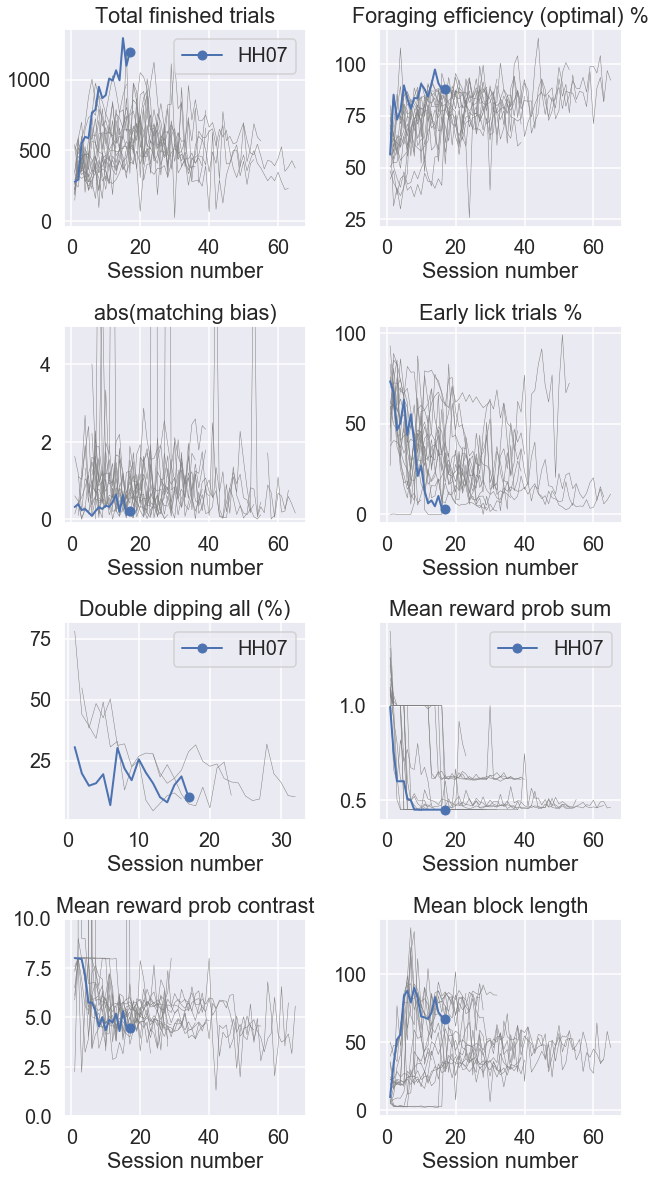

In [2]:
plot_foragingWebGUI_subject(wr_name_selected='HH07', session_selected=17)

### 2. Session panel

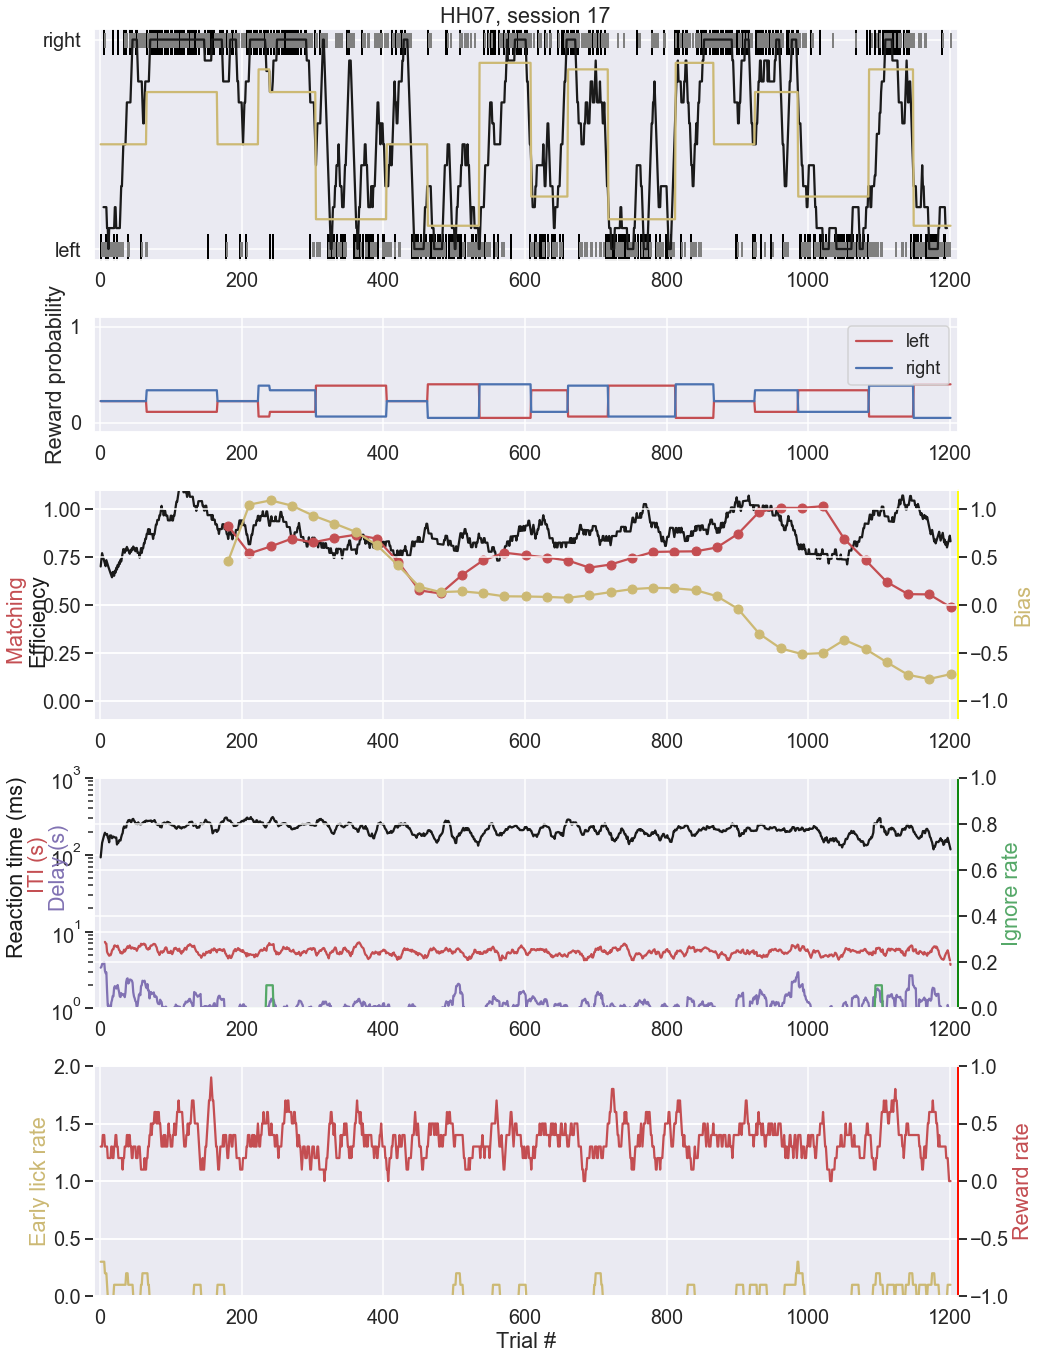

In [3]:
plot_foragingWebGUI_session(wr_name_selected='HH07', session_selected=17)

### 3. Trial panel

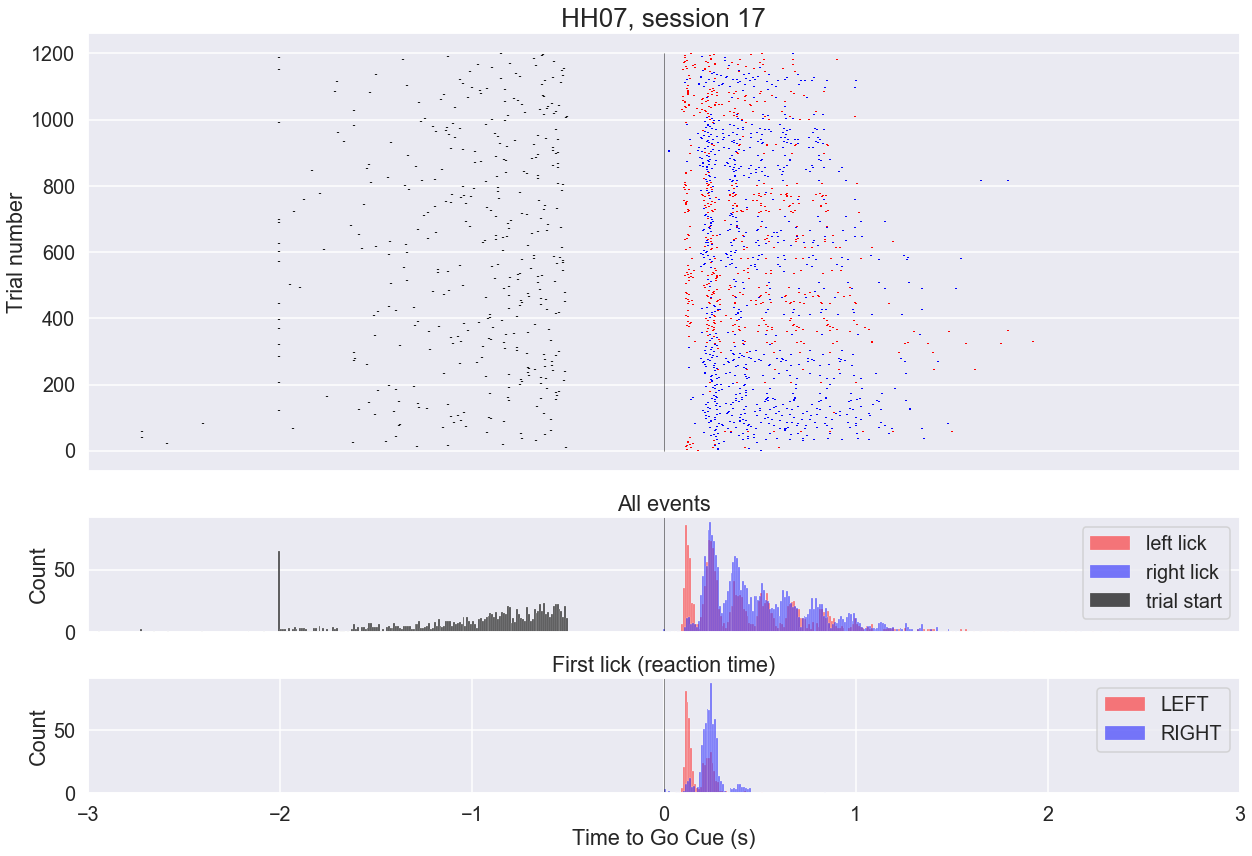

In [4]:
plot_foragingWebGUI_trial(wr_name_selected='HH07', session_selected=17)

### 4. Model panel (to be done)